This notebook explains how to get a first grid2op environment, then use the data it needs to generate some loads and renewables (and a shitty market design) and load this second environment.

In [132]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("This notebook uses the last version of grid2op. You can install it with:\n"\
      "\t{} -m pip install grid2op".format(sys.executable))
import grid2op
if grid2op.__version__ < "0.6.0":
    raise RuntimeError("Impossible to run this notebook without grid2op version 0.6.0 installed.")
from grid2op.Chronics import ChangeNothing
from grid2op.Plot import PlotMatplotlib

#path_grid = os.path.join("data", "case118_l2rpn")

This notebook uses the last version of grid2op. You can install it with:
	/opt/local/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install grid2op


In [133]:
# Chronix2grid modules
sys.path.insert(0, '..')
import generation.generate_chronics as gen
import generation.consumption.generate_load as gen_loads
import generation.renewable.generate_solar_wind as gen_enr
import generation.thermal.generate_dispatch as gen_dispatch
import generation.thermal.dispatch_utils as du

import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch
import kpi.main as kpis

In [134]:
isRunCase118=True
isRunCase14=False

# Parameters

## General parameters

In [135]:
### CONSTANT

INPUT_FOLDER = 'generation/input'
# Detailed configuration to set in <INPUT_FOLDER>/<CASE>/params.json
start_date = "2012-01-01"
weeks = 1
n_scenarios = 1

## KPI computation phase
KPI_INPUT_FOLDER = 'kpi/input'
IMAGES_FOLDER = 'kpi/images'

## Generation step of chronix2grid
if isRunCase118:
    
    CASE = 'case118_l2rpn'
    path_grid = os.path.join(INPUT_FOLDER, CASE)
    grid_path = os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json")
    OUTPUT_FOLDER = os.path.join('generation/output', CASE)
    images_folder = os.path.join(IMAGES_FOLDER, CASE)
    os.makedirs(images_folder, exist_ok=True)

    #Intermediate folder used by dispatch
    dispatch_case_folder = os.path.join(INPUT_FOLDER, CASE, 'dispatch')

if isRunCase14:

    ## Generation step of chronix2grid
    CASE = 'case14_realistic'
    path_grid = os.path.join(INPUT_FOLDER, CASE)
    grid_path = os.path.join(path_grid, "case14_realistic.json")
    OUTPUT_FOLDER = 'generation/output/case14'
    images_folder = os.path.join(IMAGES_FOLDER, CASE)
    os.makedirs(images_folder, exist_ok=True)
        
    #Intermediate folder used by dispatch
    dispatch_case_folder = os.path.join(INPUT_FOLDER, 'dispatch/case14/')

## Dispatch Parameters 

In [136]:
#20min time computation for a year with every generators at monthly resolution --- Fail on month of june
#8min time computation for a year with every generators at weekly resolution --- Fail for last 2 weeks of june
#10.5min time computation for a year with every generators at daily resolution --- Fail for 17 and 24 of june 
#=>no thermal on those days, probably due to ramps! But was converging when looking only per carrier type

#1min time computation for a year with every carrier at monthly resolution --- Fail on month of june
#6min time computation for a year with every carrier at daily resolution --- Fail on month of june


# Run the dispatch in the automated process or "manually"
run_automated_dispatch = False

losses_pct = 3.0
DispatchByCarrierOnly=False

params_opf = {
    'step_opf_min': 5,
    'mode_opf': 'month',
    'reactive_comp': 1.025,
    'losses_pct': losses_pct,
    'dispatch_by_carrier': DispatchByCarrierOnly
}

# Load the environment

In [137]:
env118_withoutchron = grid2op.make("blank",  # to generate a blank environment
                      grid_path=grid_path, # assign it the 118 grid
                      chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
                  )

# Check the Energy Mix apriori

In [138]:
%run kpi/Generator_parameter_checker.py
Target_EM_percentage=pd.DataFrame(data=[4,6,35,15,40],columns=['target_energy_mix'],
                                  index=['solar','wind','nuclear','hydro','thermal'])

if isRunCase14:
    PeakLoad=308
    AverageLoad=257
elif isRunCase118:
    PeakLoad=4200
    AverageLoad=2800
    
CapacityFactor=pd.DataFrame(data=[15,25,95,30,np.nan],columns=['capacity_factor'],
                            index=['solar','wind','nuclear','hydro','thermal'])
Capacity_df=EnergyMix_AprioriChecker(env118_withoutchron,Target_EM_percentage, PeakLoad, AverageLoad, CapacityFactor )
Capacity_df

,target_energy_mix,pmax,capacity_mix,capacity_factor,Apriori_energy_mix,revised_pmax
solar,4,747.0,10.3,15.0,4.001786,746.666667
wind,6,672.0,9.3,25.0,6.000000,672.000000
nuclear,35,1031.7,14.3,95.0,35.004107,1031.578947
hydro,15,1618.0,22.4,30.0,17.335714,1400.000000
thermal,40,3168.5,43.8,NaN,37.658393,3168.421053


# II Generate the data

**You can set generation configuration such as number of scenarios, start date, number of weeks, noise intensities, timestep... in INPUT_FOLDER/CASE/params.json**

# II A) Generate loads and renewables

Chronix2grid generation process which implements Balthazar method. CSV writting takes long

In [139]:
## Reading parameters
year, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE, start_date, weeks)
print(year)

## Whole generation
# gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)


## OR ============

# Separate generation for load and renewables


# Create folders
dispatch_input_folder = os.path.join(dispatch_case_folder, str(year))
dispatch_output_folder = os.path.join(OUTPUT_FOLDER, str(year))
os.makedirs(dispatch_input_folder, exist_ok=True)
os.makedirs(dispatch_output_folder, exist_ok=True)

# Make sure the seeds are the same, whether computation is parallel or sequential
seeds = [np.random.randint(low=0, high=2**31) for _ in range(n_scenarios)]


# Launch load generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    load, load_forecasted = gen_loads.main(i, dispatch_input_folder, seed, params, loads_charac, 
                                           load_weekly_pattern, write_results = True)

    print('\n')

Importing parameters ...
Importing loads prods and lines parameters ...
2012
================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv in "generation/input/case118_l2rpn/dispatch/2012/Scenario_0"




In [140]:
!ls $OUTPUT_FOLDER

2012          agent_results


## Check load hypothesis (peak and average)

**if this differs by too much, you should update the computation of the Energy Mix a priori and revise some calibration if not satisfactory**

In [141]:
CurrentPeakLoad=load.sum(axis=1).max()
print('the expected peak load was: '+str(PeakLoad))
print('the actual peak load is: '+str(CurrentPeakLoad))

the expected peak load was: 4200
the actual peak load is: 3859.6086806944945


In [142]:
CurrentAverageLoad=load.sum(axis=1).mean()
print('the expected average load was: '+str(AverageLoad))
print('the actual average load is: '+str(CurrentAverageLoad))

the expected average load was: 2800
the actual average load is: 3122.6661118396705


## Generate Renewables

In [143]:
dispatcher = ec.Dispatcher.from_gri2op_env(env118_withoutchron)

# move the 2 following lines inside the loop if they should be different for each scenario
dispatcher.modify_marginal_costs({'hydro': 3, 'nuclear': 8})
dispatcher.read_hydro_guide_curves(os.path.join(INPUT_FOLDER, 'patterns', 'hydro_french.csv'))

# Launch solar and wind generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    
    scenario_name = f'Scenario_{i}'
    input_scenario_folder, output_scneario_folder = du.make_scenario_input_output_directories(
        dispatch_input_folder, dispatch_output_folder, scenario_name)
    
    prod_solar, prod_solar_forecasted, prod_wind, prod_wind_forecasted = gen_enr.main(i, dispatch_input_folder, seed,params, prods_charac, solar_pattern, 
                                                                                 write_results = True)
    
    if run_automated_dispatch:
        prods = pd.concat([prod_solar, prod_wind], axis=1)
        res_names = dict(wind=prod_wind.columns, solar=prod_solar.columns)
        dispatcher.chronix_scenario = ec.ChroniXScenario(load, prods, res_names, scenario_name)

        dispatch_results = gen_dispatch.main(dispatcher, input_scenario_folder, output_scneario_folder, 
                                             seed, params_opf)
    print('\n')

================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv




In [144]:
!ls generation/output/case14/2012/

Scenario_0    Scenario_12   Scenario_2    Scenario_6    agent_results
Scenario_1    Scenario_13   Scenario_3    Scenario_7
Scenario_10   Scenario_14   Scenario_4    Scenario_8
Scenario_11   Scenario_15   Scenario_5    Scenario_9


In [145]:
## Reading parameters
#year, n_scenarios, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE)
#print(year)
#gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)

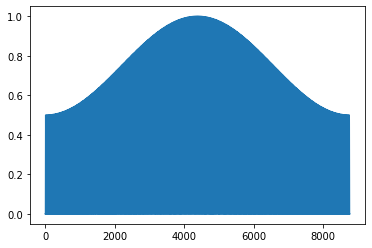

In [146]:
plt.plot(solar_pattern)

## Check Ramps and Pmin/Pmax Generator parameters A priori

### Select the scenario you want to check first

In [147]:
%run kpi/Generator_parameter_checker.py

# losses_pct = 3.0  # losses as pct of load
[isThermalInTrouble,isNuclearInTrouble,IsRampUpInTrouble,IsRampDownInTrouble]=Ramps_Pmax_Pmin_APrioriCheckers(
    env118_withoutchron,Capacity_df,dispatch_input_folder,losses_pct,PeakLoad)


 the wind share is 3.3
the wind share was expected to be 6
the solar share is 1.6
the solar share was expected to be 4

 the max load is 3975.2850000000003
the expected peak load was 4200

 the max net load is 3631.3930000000005

 the min net load is 2281.7999999999993
the nuclear capacity is 1031.6999999999998
the max net load decrease 50.95399999999927
the nuclear max ramp Down is 7.164583333333333
are we in trouble for nuclear:False

 the max net load ramp up is 50.95399999999927
the max generation ramp up is 160.16325242391596

 the max net load ramp down is -52.79499999999962
the max nuclear + hydro ramp down is 74.58125000000001


In [148]:
print("Are the thermal reactors \"in trouble\": {}".format(isThermalInTrouble))
print("Are the nuclear reactors \"in trouble\": {}".format(isNuclearInTrouble))
print("Are the ramp up \"in trouble\": {}".format(IsRampUpInTrouble))
print("Are the ramp down \"in trouble\": {}".format(IsRampDownInTrouble))

Are the thermal reactors "in trouble": True
Are the nuclear reactors "in trouble": False
Are the ramp up "in trouble": False
Are the ramp down "in trouble": False


In [149]:
%run kpi/Generator_parameter_checker.py
Aposteriori_renewableCapacityFactor_Checkers(env118_withoutchron,Capacity_df, dispatch_input_folder)


 the max wind production 219.89999999999998

 the expected max wind production was 672.0000000000001

 the max solar production 324.0

 the expected max solar production was 747.0000000000001

 the solar capacity factor is: 0.06922538790397319

 the expected solar capacity factor was: 15.0

 the wind capacity factor is: 0.1563402457757296

 the expected wind capacity factor was: 25.0


[0.06922538790397319, 0.1563402457757296]

## Compute some KPIs for solar, wind and load only

#### Benchmark "France" is set as reference in KPI_INPUT_FOLDER/paramsKPI.json
Images are saved in IMAGES_FOLDER/CASE/YEAR/SCENARIO

================================================= KPI GENERATION  ===================================================================
Scenario 0...
Importing and formatting data downloaded from Renewable Ninja API
Importing and formatting synthetic chronics
(1) Computing KPI's...

(2) Generating json output file...
-Done-



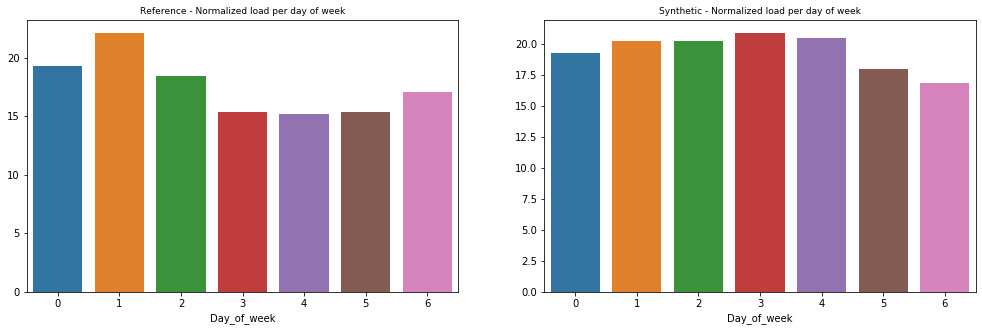

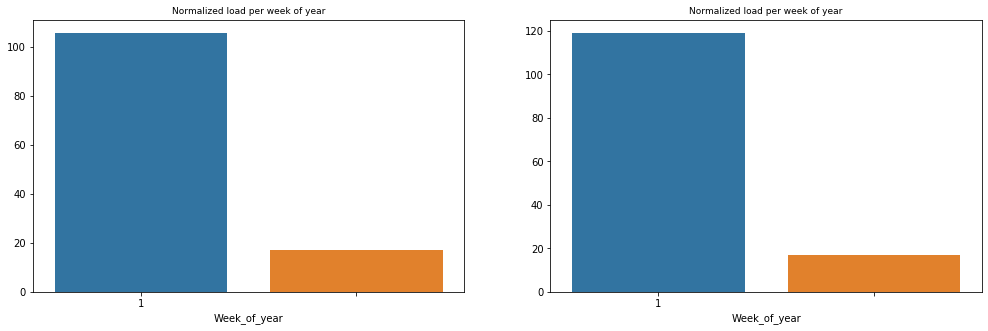

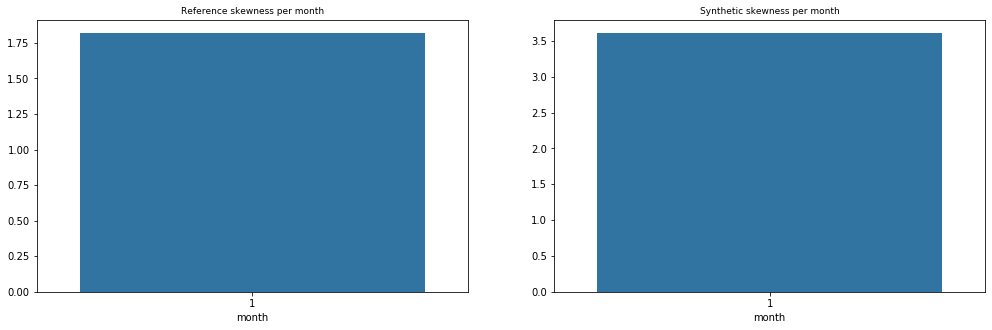

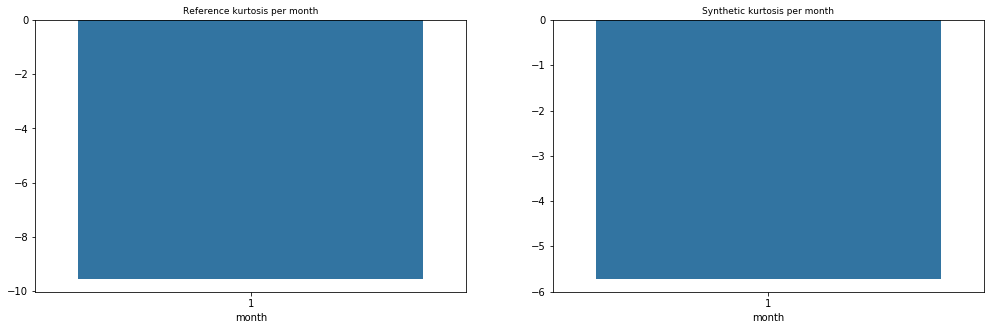

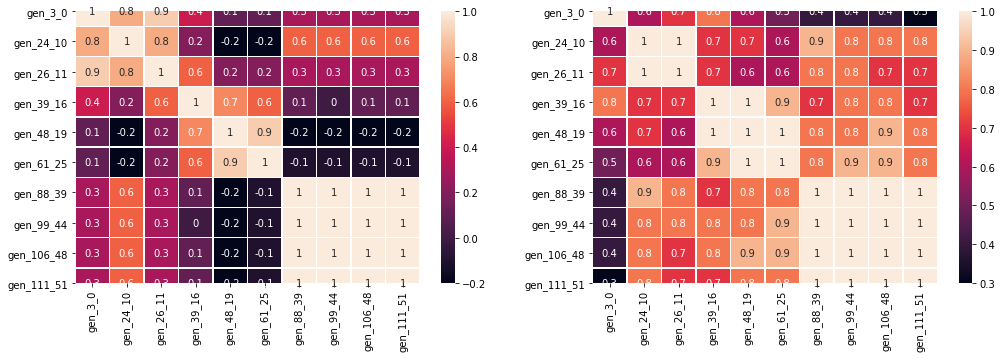

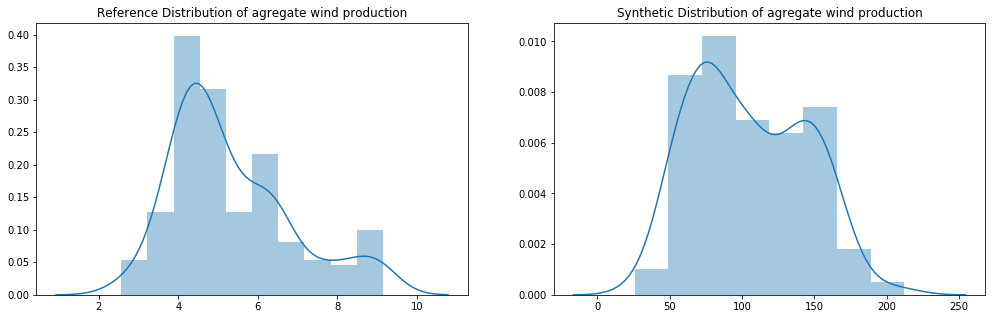

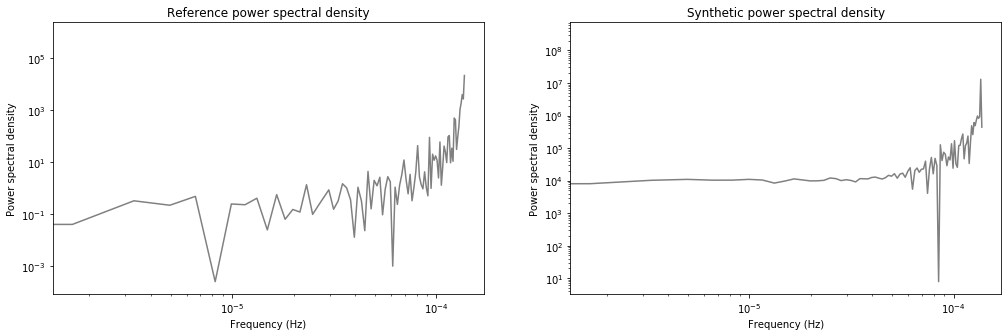

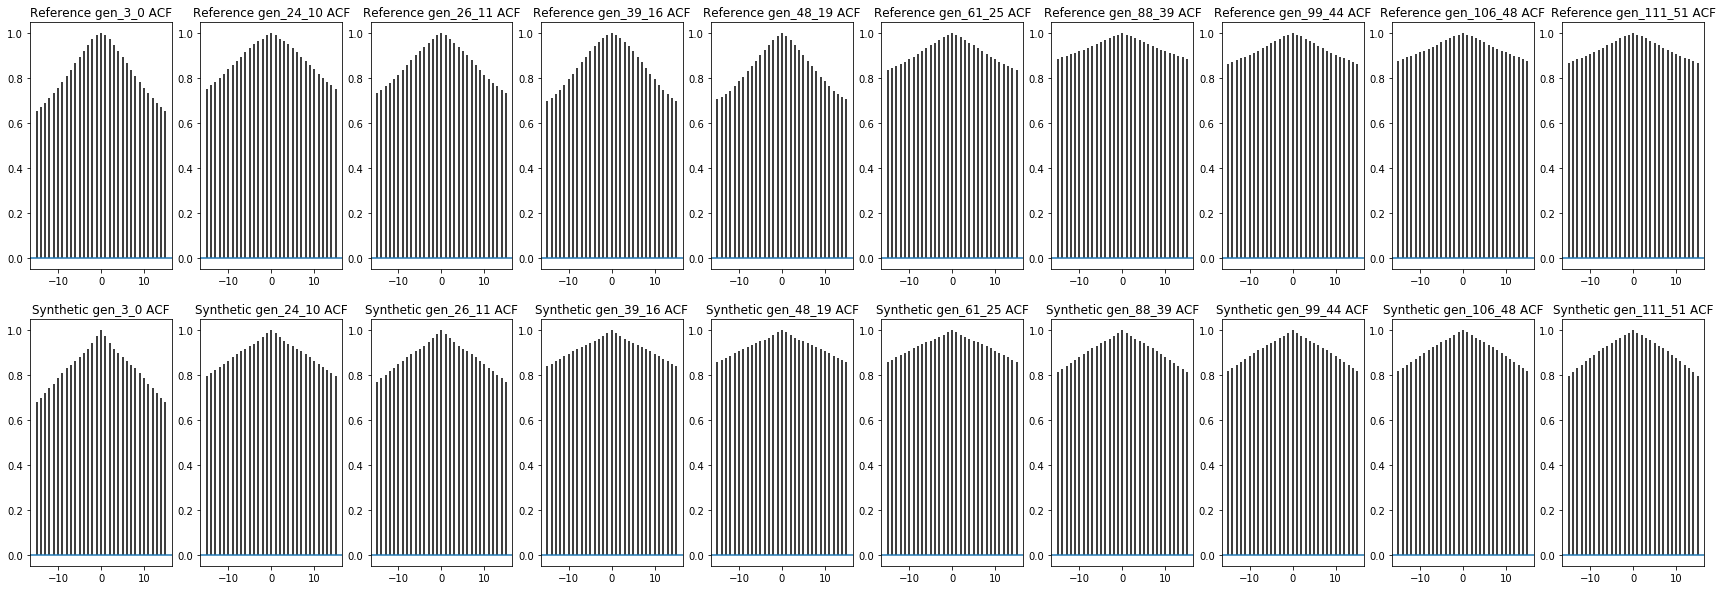

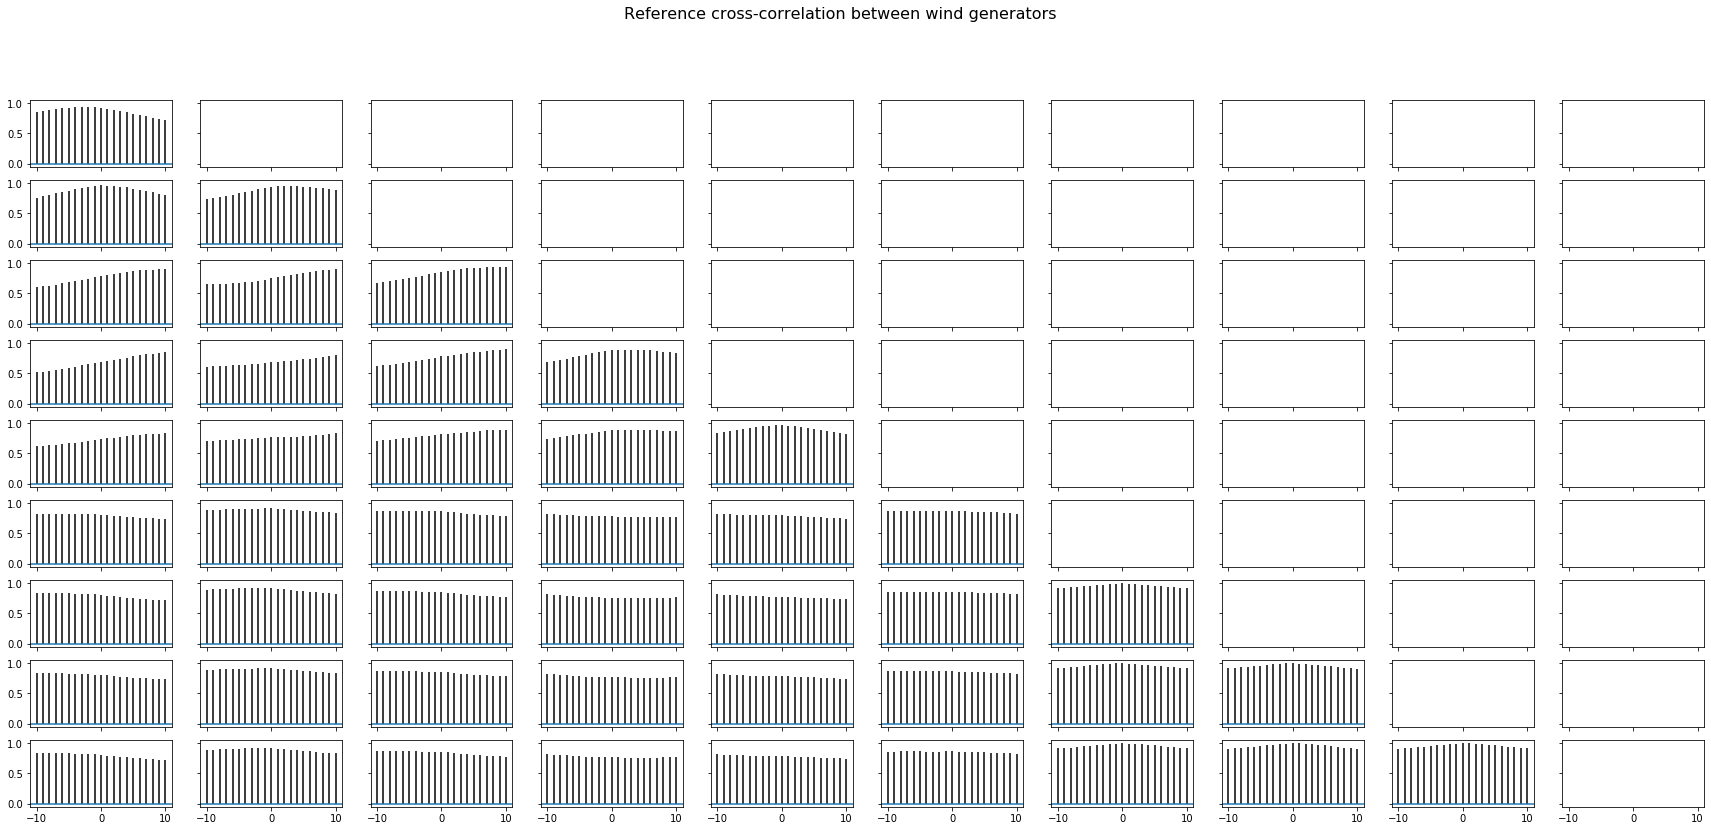

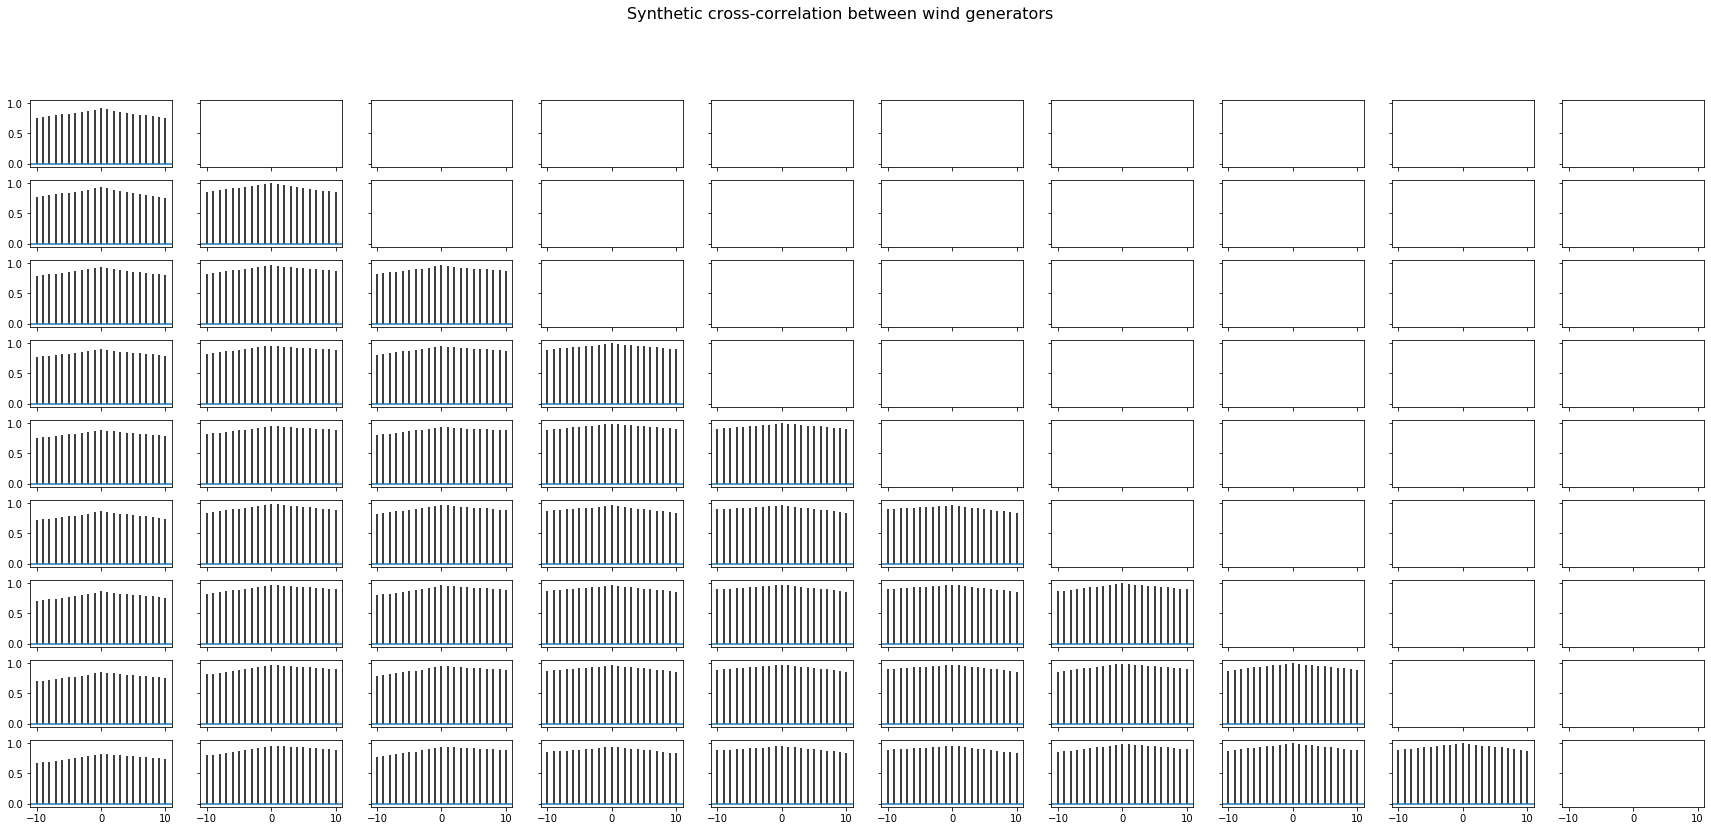

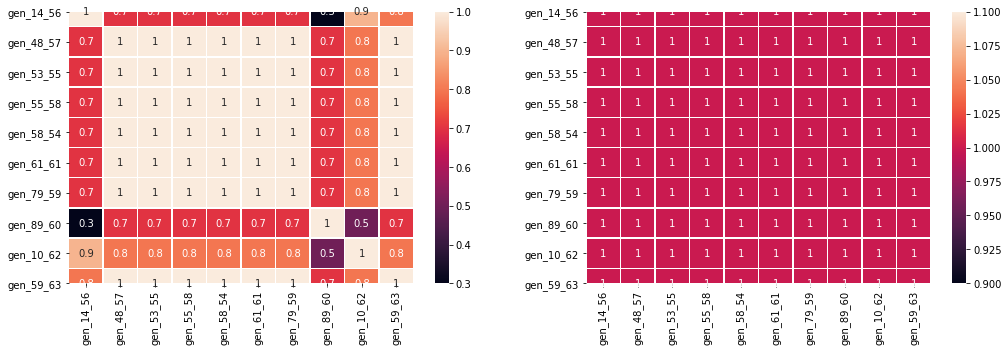

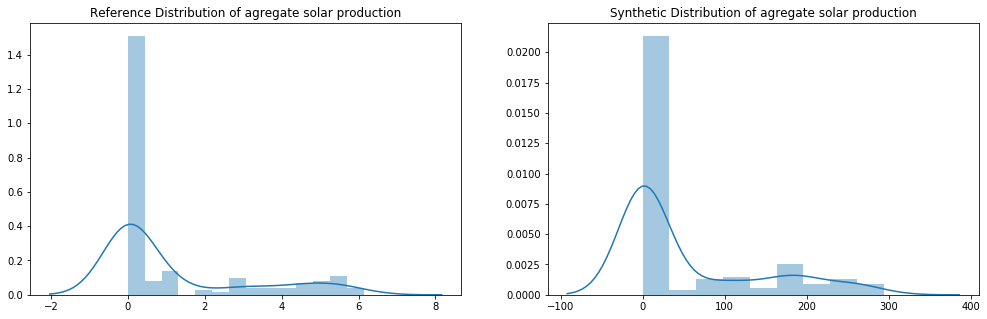

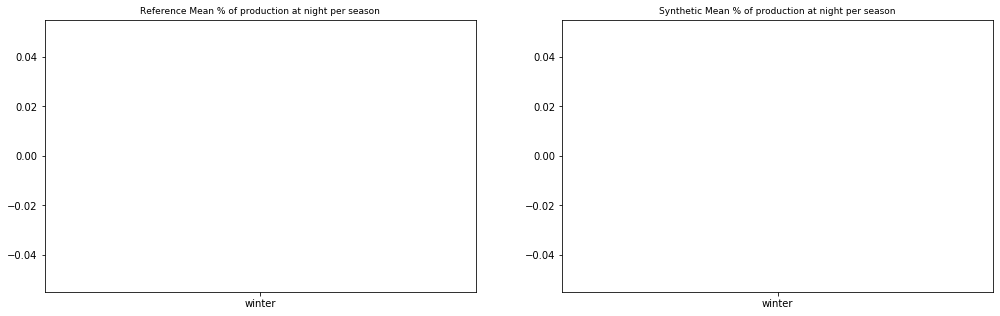

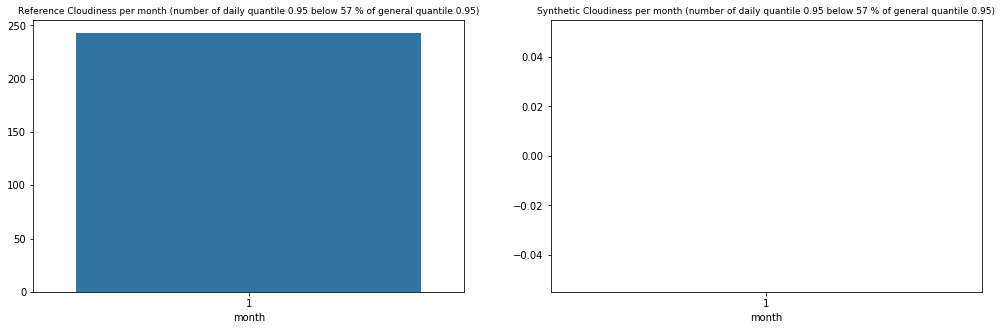

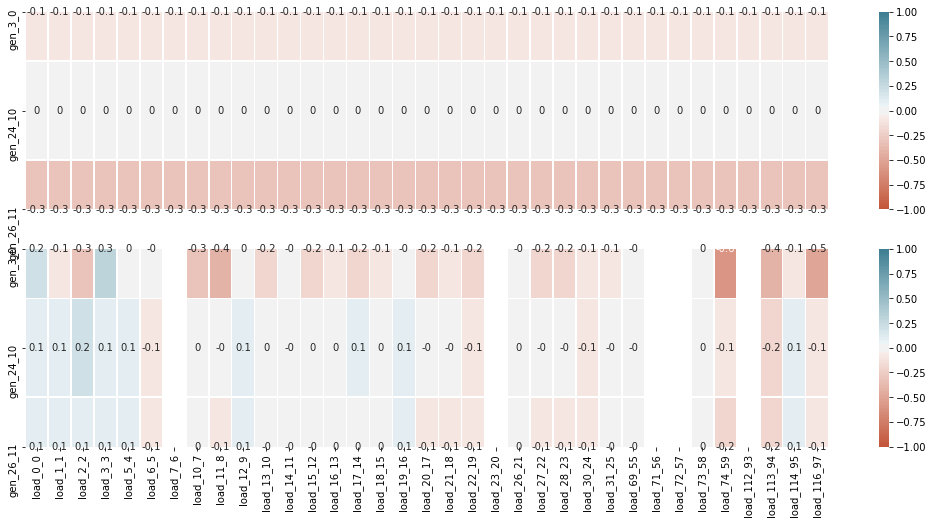

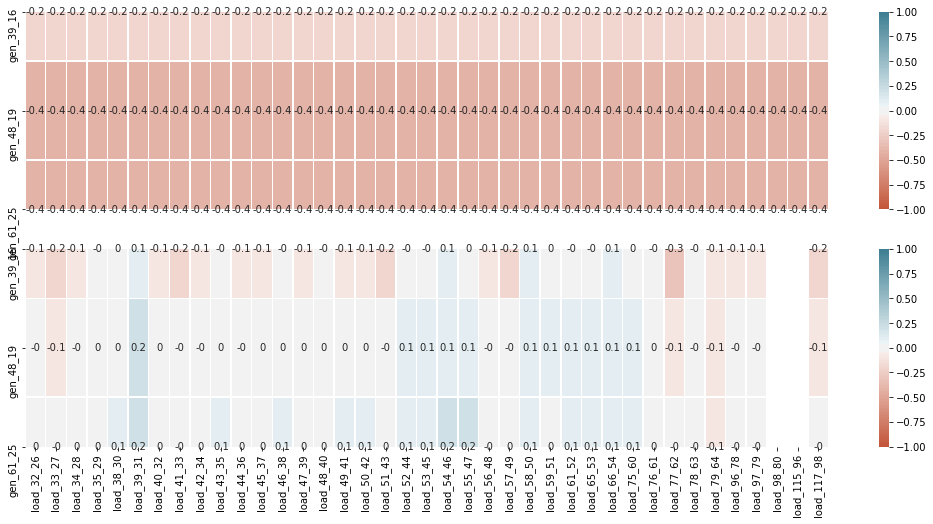

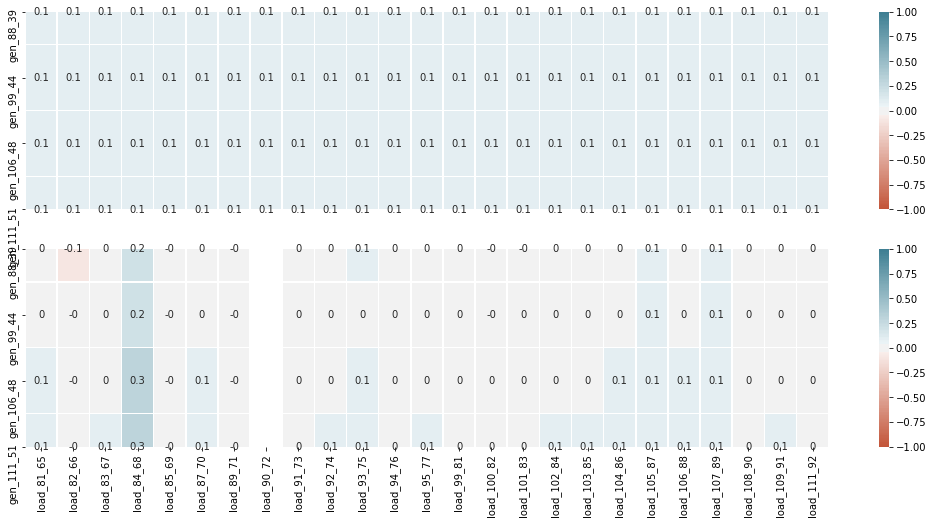

In [150]:
# If you just want to save a lot of plots without showing it, uncomment this line.
# If you want to compute more than 1 scenario, it is recommended not to show the plots on notebook
#%%capture

# Chose number of scenarios to compute KPIs (it can be long to compute it for a lot of scenarios)
n_scenarios_kpis = 1

# Computation
wind_solar_only = True
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, images_folder, year, CASE, n_scenarios_kpis, wind_solar_only, params, loads_charac, prods_charac)

## Create The EconomicDispatch instance : a high level wrapper around a Pypsa net

To install PyPSA correctly <br>
`pip3 install -U git+http://github.com/PyPSA/PyPSA.git@8d527e25fa9876cac66957448f449a1c901901d2`

You also need to install the solver that pypsa is calling. For instance cbc solver. On Fedora do `dnf install coin-or-Cbc.x86_64`

In [151]:
%load_ext autoreload
%autoreload 2
import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
dispatcher = ec.Dispatcher.from_gri2op_env(env118_withoutchron)
dispatcher.modify_marginal_costs({'hydro': 3, 'nuclear': 8})
dispatcher.read_hydro_guide_curves(os.path.join(INPUT_FOLDER, 'patterns', 'hydro_french.csv'))

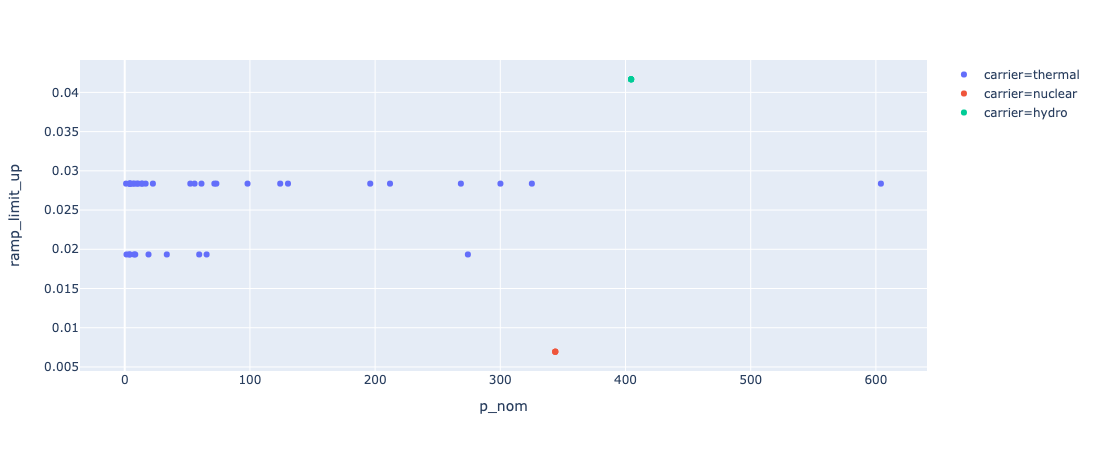

In [153]:
dispatcher.plot_ramps()

## II B) Run a unit commitment model

we will use pypsa. To avoid messing with the names, and make sure to have data in the proper shape, it is better, I think, to create the pypsa network directly from the grid2op environment.

For more information on unit commitment see https://pypsa.org/examples/unit-commitment.html for example.

### Run opf

In [155]:
if not run_automated_dispatch:

    # The run is by scenario
    for subpath in os.listdir(dispatch_input_folder):

        if subpath in ['.DS_Store']:
            continue

        this_path = os.path.join(dispatch_input_folder, subpath)
        dispatcher.read_load_and_res_scenario(os.path.join(this_path, 'load_p.csv.bz2'),
                                            os.path.join(this_path, 'prod_p.csv.bz2'),
                                            scenario_name=subpath)
        hydro_constraints = dispatcher.make_hydro_constraints_from_res_load_scenario()
        agg_load_without_renew = dispatcher.net_load(losses_pct, name=dispatcher.loads.index[0])

        # Example of how to extract info on the largest ramps
        print(f'5 largest ramps reached by the agg_load_without_renew:')
        print(dispatcher.nlargest_ramps(5, losses_pct))

        # Run Economic Disptach using submodule EDisptach_L2RPN_2020
        # **  **  **  **  **  **  **  **  **  **  **  **  **  **
        dispatch_results = dispatcher.run(
                                            agg_load_without_renew,
                                            params=params_opf,
                                            gen_constraints=hydro_constraints,
                                            ramp_mode=run_economic_dispatch.RampMode.hard,
                                            by_carrier=DispatchByCarrierOnly  # True to run the dispatch only aggregated generators by carrier
                                        )

        chronix_scenario = dispatch_results.chronix

        # save prods chronics
        dispatcher.save_results(os.path.join(dispatch_output_folder, subpath))

        #TODO this should not be done in the notebook, but in chronix2grid ! These files are output of chronix2grid.
        import shutil
        files_to_move = ['load_p_forecasted.csv.bz2', 'load_q_forecasted.csv.bz2',
                     'load_q.csv.bz2', 'prod_v.csv.bz2']
        for file_to_move in files_to_move:
            shutil.copy(os.path.join(dispatch_input_folder, subpath, file_to_move),
                        os.path.join(dispatch_output_folder, subpath, file_to_move))
    # TODO if there are failures, write it somewhere, for now it's only detected in the very verbose output cell.
    # for example you can do a report at the end 'looking like failures for scenariis xxx'

INFO:pypsa.linopf:Prepare linear problem


5 largest ramps reached by the agg_load_without_renew:
                           
datetime                   
2012-01-01 12:15:00  50.954
2012-01-01 11:15:00  49.035
2012-01-02 11:50:00  46.842
2012-01-02 22:50:00  44.884
2012-01-01 12:20:00  43.360
Preprocessing input data..
Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.78e+08


-- opf succeeded  >Objective value (should be greater than zero!
Total time 0.32 min
OPF Done......
Saving results for the grids with individual generators...
Saving chronics into generation/output/case118_l2rpn/2012/Scenario_0


chronix_scenario is an object containing all the time series related to the studied scenario : 
- chronix_scenario.name gives the name of the scenario
- chronix_scenario.wind_p (resp. solar_p, prods_dispatch, loads, marginal_prices) gives the Wind DataFrame (resp. Solar, Dispatched generators, loads, marginal_prices)

This object should be manipulated in the sequel.

### The code below (up until the kpis) will  not run if  run_automated_dispatch = True

In [156]:
#check that the max net load is similar than after generating loads and renewables
agg_load_without_renew.max()

agg_load    3631.393
dtype: float64

### Check That Pypsa does not violate the ramps

In [184]:
StatsRamps=full_opf_dispatch.diff().describe()
maxRamps=StatsRamps.loc['max']
maxRamps[maxRamps>=10]

gen_11_4     15.40
gen_17_6     15.40
gen_53_20    15.40
gen_58_23    15.40
gen_65_27    17.14
Name: max, dtype: float64

In [189]:
gen_names=list(env118_withoutchron.name_gen)
matchIDs=[gen_names.index(el) for el in namesGenNonRenewable]
gen_ramps=env118_withoutchron.gen_max_ramp_up#[matchIDs]
gen_subIds=env118_withoutchron.gen_to_subid#[matchIDs]

RampsToHigh=((maxRamps>gen_ramps).values & (gen_ramps!=0))
print('\n generation above their max rated ramps')
print(gen_subIds[RampsToHigh])
print('\n max ramps in environement for generation above their max rated ramps')
print(pd.DataFrame(gen_ramps,index=gen_names).loc[RampsToHigh])
print('\n max ramps after pypsa')
print(maxRamps[RampsToHigh])


 generation above their max rated ramps
[  9  14  18  30  35  45  54  55  60  65  68  69  73  79  81  86  91  98
 103 104 109 110 112 115]

 max ramps in environement for generation above their max rated ramps
                    0
gen_9_3      5.300809
gen_14_5     1.150668
gen_18_7     1.264768
gen_30_12    0.649789
gen_35_15    0.145042
gen_45_18    0.113475
gen_54_21    1.486525
gen_55_22    2.031206
gen_60_24    3.523404
gen_65_27   17.134752
gen_68_28    8.513475
gen_69_29    0.380142
gen_73_32    0.473759
gen_79_35    6.011348
gen_81_36    2.782979
gen_86_38    9.225532
gen_91_42    7.617021
gen_98_43    5.563121
gen_103_46   2.076596
gen_104_47   0.638298
gen_109_49   0.113475
gen_110_50   3.699291
gen_112_52   1.739007
gen_115_53   1.582979

 max ramps after pypsa
gen_9_3        5.31
gen_14_5       1.16
gen_18_7       1.27
gen_30_12      0.65
gen_35_15      0.15
gen_45_18      0.12
gen_54_21      1.49
gen_55_22      2.04
gen_60_24      3.53
gen_65_27     17.14
gen_68_28      

### Plot the dispatch

In [157]:
# Concatenate renewable dispatch

#Becareful:check years of opf_dispatch and dispatch
print(chronix_scenario.wind_p.index[0])
print(chronix_scenario.prods_dispatch.index[0])

2012-01-01 00:00:00
2012-01-01 00:00:00


In [158]:
if(chronix_scenario.wind_p.index[0] != chronix_scenario.prods_dispatch.index[0]):
    chronix_scenario.prods_dispatch.index=chronix_scenario.wind_p.index
if DispatchByCarrierOnly:
    chronix_scenario.prods_dispatch=chronix_scenario.prods_dispatch[['nuclear','hydro','thermal']]#makesure nuclear comesfirst, for good plotting after

full_opf_dispatch = pd.concat(
    [chronix_scenario.prods_dispatch, chronix_scenario.wind_p, chronix_scenario.solar_p],
    axis=1
)

# Keep same order as grid2op
if not DispatchByCarrierOnly:
    full_opf_dispatch = full_opf_dispatch[env118_withoutchron.name_gen].round(2)

In [159]:
env118_withoutchron.name_gen

array(['gen_3_0', 'gen_5_1', 'gen_7_2', 'gen_9_3', 'gen_11_4', 'gen_14_5',
       'gen_17_6', 'gen_18_7', 'gen_23_8', 'gen_25_9', 'gen_24_10',
       'gen_26_11', 'gen_30_12', 'gen_31_13', 'gen_33_14', 'gen_35_15',
       'gen_39_16', 'gen_41_17', 'gen_45_18', 'gen_48_19', 'gen_53_20',
       'gen_54_21', 'gen_55_22', 'gen_58_23', 'gen_60_24', 'gen_61_25',
       'gen_64_26', 'gen_65_27', 'gen_68_28', 'gen_69_29', 'gen_71_30',
       'gen_72_31', 'gen_73_32', 'gen_75_33', 'gen_76_34', 'gen_79_35',
       'gen_81_36', 'gen_84_37', 'gen_86_38', 'gen_88_39', 'gen_89_40',
       'gen_90_41', 'gen_91_42', 'gen_98_43', 'gen_99_44', 'gen_102_45',
       'gen_103_46', 'gen_104_47', 'gen_106_48', 'gen_109_49',
       'gen_110_50', 'gen_111_51', 'gen_112_52', 'gen_115_53',
       'gen_58_54', 'gen_53_55', 'gen_14_56', 'gen_48_57', 'gen_55_58',
       'gen_79_59', 'gen_89_60', 'gen_61_61', 'gen_10_62', 'gen_59_63'],
      dtype='<U10')

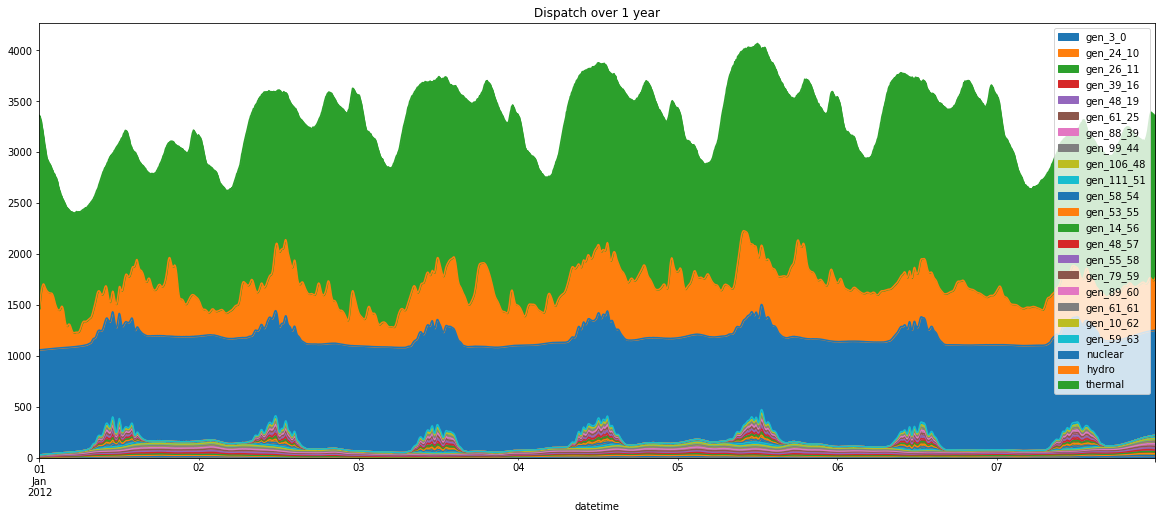

In [160]:
if not DispatchByCarrierOnly:
    nuclear_names = dispatcher.generators[dispatcher.generators.carrier == 'nuclear'].index
    hydro_names = dispatcher.generators[dispatcher.generators.carrier == 'hydro'].index
    thermal_names = dispatcher.generators[dispatcher.generators.carrier == 'thermal'].index

    dispatch_by_fleet=pd.concat([ dispatcher.wind_p, dispatcher.solar_p], axis=1)
    dispatch_by_fleet['nuclear'] = full_opf_dispatch[nuclear_names].sum(axis=1).to_frame('Nuclear')
    dispatch_by_fleet['hydro'] = full_opf_dispatch[hydro_names].sum(axis=1)
    dispatch_by_fleet['thermal'] = full_opf_dispatch[thermal_names].sum(axis=1)
    #dispatch_by_fleet=pd.concat([dispatch_by_fleet, dispatch.wind_p, dispatch.solar_p], axis=1)

    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0

    # grid2op env starts in 2007 but read loads are in 2012...
    #dispatch_by_fleet = dispatch_by_fleet.loc[dispatch_by_fleet.index.year == 2007,:]

    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')

else:
    dispatch_by_fleet=full_opf_dispatch
    
    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0 #due to numeric approximation,some thermal values  could be negative
    dispatch_by_fleet.loc[dispatch_by_fleet['hydro'] < 0, 'hydro'] = 0
    #full_opf_dispatch[full_opf_dispatch['thermal']<0]['thermal'].hist()
    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')


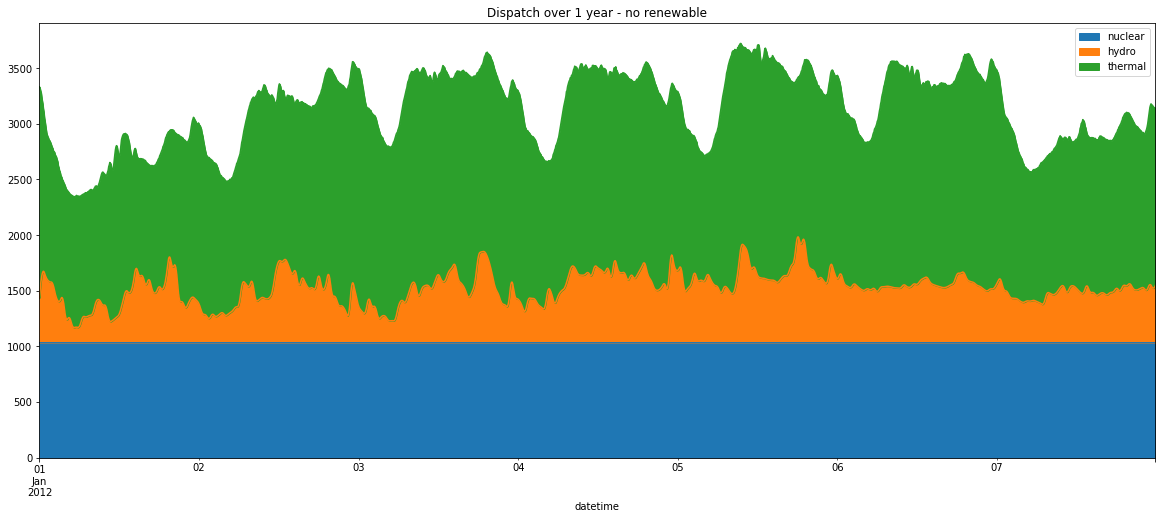

In [161]:
dispatch_by_fleet[['nuclear','hydro','thermal']].plot(figsize=(20, 8), title='Dispatch over 1 year - no renewable', kind='area')

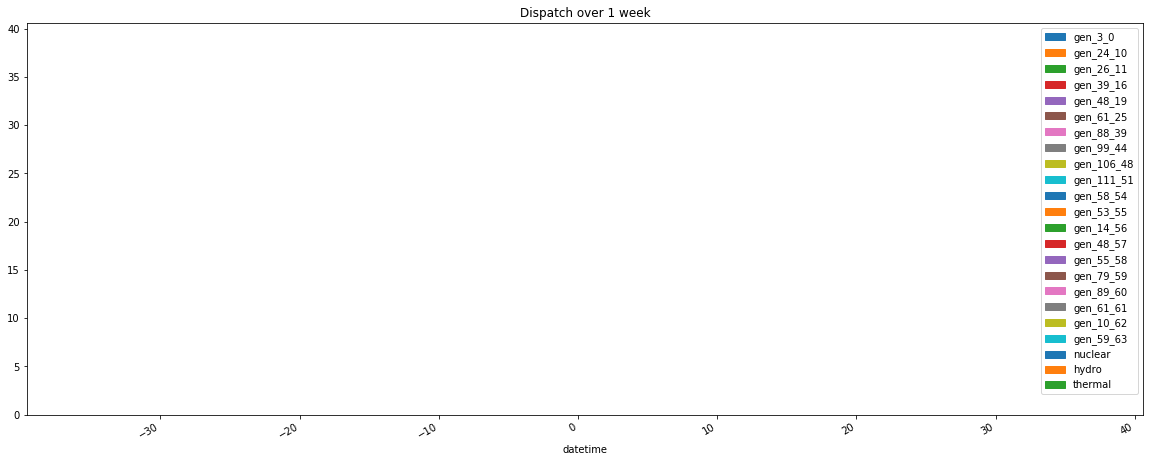

In [162]:
WeekNumber=24
dispatch_by_fleet.iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week', kind='area')

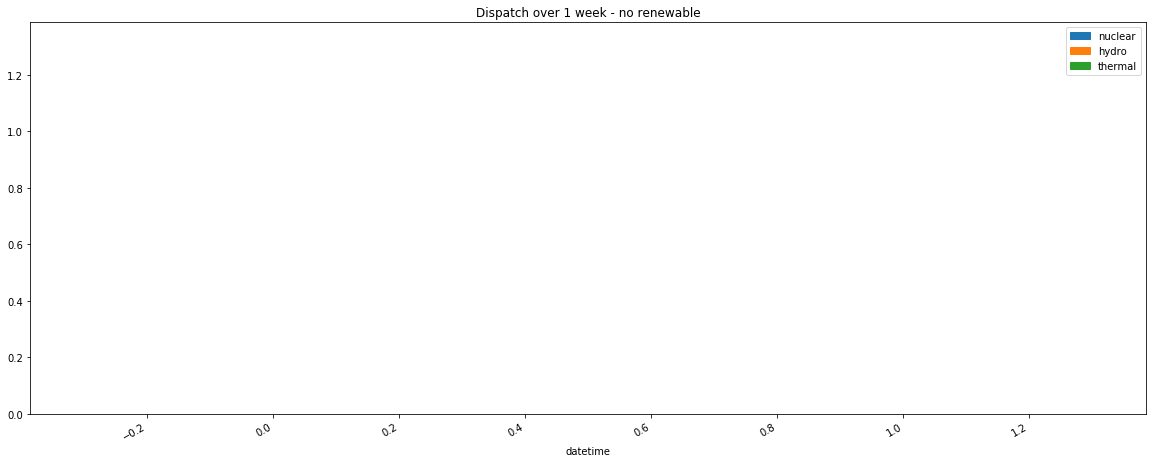

In [163]:
dispatch_by_fleet[['nuclear','hydro','thermal']].iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week - no renewable', kind='area')

Check Hydro 

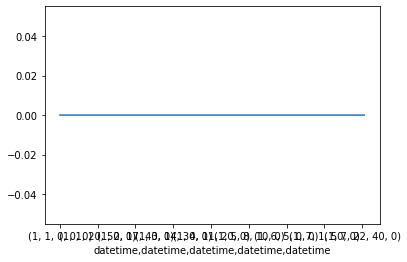

In [164]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    minHydroPattern=dispatcher._min_hydro_pu
    nCols=minHydroPattern.shape[1]
    minHydroPattern.iloc[:,0].plot()

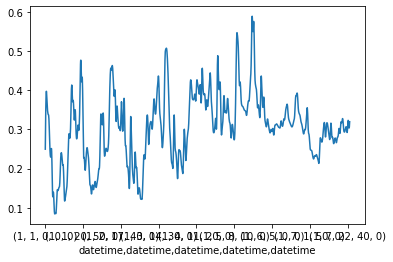

In [165]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    maxHydroPattern=dispatcher._max_hydro_pu
    nCols=maxHydroPattern.shape[1]
    maxHydroPattern.iloc[:,0].plot()

In [166]:
# Validate whether they have same order
np.all(full_opf_dispatch.columns == env118_withoutchron.name_gen)

True

Check Energy Mix of Dispatch and capacity factors

In [167]:
CurrentAverageLoad=load.sum(axis=1).mean()
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/CurrentAverageLoad

nuclear    0.330391
hydro      0.158640
thermal    0.515261
dtype: float64

In [168]:
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/dispatch_by_fleet[['nuclear','hydro','thermal']].max()

nuclear    1.000000
hydro      0.520008
thermal    0.738627
dtype: float64

### Compute some KPIs for dispatch
As I never had a dispatch output file, I didn't have a precise output format for the dispatch to be taken into account by the KPI module.So I chose to take the format of the only example i had: chronics exported by a previous script of Camilo with month by month dispatch chronics. 
- Download these files to have a format example on Nextcloud: https://nextcloud.artelys.com/nextcloud/s/tFirA3TRXrHeFwC
- Careful, this example is for year 2007
- We should agree on an output format from dispatch. Maybe you could put it on Nextcloud as an example for me

#### You have to set "eco2mix" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
**Images were not designed to be plot on a notebook but to be saved as png or zoomable in IMAGES_FOLDER**. In particular, yearly productions and energy mix are better to watch in their written files

In [169]:
%%capture

wind_solar_only = False
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, images_folder, year, CASE, n_scenarios, wind_solar_only, params, loads_charac, prods_charac)

# III Create an environment with the chronics this time

This is to test the environment can be used by grid2op. This is what the "case118_l2rpn" will look like for the competitions.

**NB** The "Balthazar code" is fully compatible with the "GridStateFromFileWithForecasts". So it is useful to use this class to load back the data. If the data generation process does not provide the same utilities, it is not a problem to write another class, like "GridStateFromFileWithForecasts" that can read its format.

### Correct the bug in element 7_4_173

In [170]:
# NO YOU SHOULD NOT DO THAT BUT BE ABLE TO RUN ALL SCENARIOS IN THE RUNNER.

# Chose generated scenario
# scenario = 'Scenario_15'
# scenario_path = os.path.join(OUTPUT_FOLDER, str(year), scenario)


** I can't run from the following cell: can't make the dispatch run on my machine and don't data in the right format**

In [171]:
from grid2op.Chronics import Multifolder, GridStateFromFileWithForecasts
from grid2op.Parameters import Parameters
try:
    from lightsim2grid.LightSimBackend import LightSimBackend
    backend = LightSimBackend()
except:
    from grid2op.Backend import PandaPowerBackend
    backend = PandaPowerBackend()
    print("You might need to install the LightSimBackend (provisory name) to gain massive speed up")
# don't disconnect powerline on overflow, the thermal limit are not set for now, it would not make sens
param = Parameters()
param.init_from_dict({"NO_OVERFLOW_DISCONNECTION": True})

env = grid2op.make("blank",  # to generate a blank environment
                   grid_path=grid_path, # assign it the 118 grid
                   chronics_class=Multifolder, # tell it to change nothing (not the most usable environment...)
                   data_feeding_kwargs= {
                       "path": os.path.abspath(dispatch_output_folder), "gridvalueClass": GridStateFromFileWithForecasts},
                   param=param,
                   backend=backend
                  )
# If you remove the "GridStateFromFileWithForecasts", from above, chronics will NOT be loaded properly.
# GridStateFromFileWithForecasts is the format used for the competition, so it is mandatory that this works!
# WITHOUT ANY MODIFICATIONS

# Beside the environment should be able to load all data generated, and not one episode.
# so please look in grid2op for compatible formats. This is not a valid format.

In [172]:
print("Have all the chronics been loaded: {}".format(len(env.chronics_handler.real_data.subpaths) == n_scenarios))

Have all the chronics been loaded: True


In [173]:
#set env thermal limit to 1 by default
th_lim = np.ones(env.n_line, dtype=np.float)
env.set_thermal_limit(th_lim)

And now we can test that we can use a Runner, store the results, and plot the flows on the powerline for example

# IV Validate the generation process

For that we use a runner, that will compute the powerflows with a "do nothing" agent, and we prevent it to disconnect any power line, even if they are on overflow.

In [179]:
from grid2op.Runner import Runner
import tempfile
from tqdm.notebook import tqdm

path_data_saved = os.path.join(os.path.abspath(os.path.join(dispatch_output_folder, os.pardir)), 'agent_results', scenario_name)
os.makedirs(path_data_saved, exist_ok=True)

nb_episode = n_scenarios
# nb_episode = n_scenarios
#nb_steps = 400
runner = Runner(**env.get_params_for_runner())

# here you might need to change "nb_episode" if you generated more than one scenario
# this might really take some times... 4 mins per scenario per week [on one core]
res = runner.run(nb_episode=nb_episode, path_save=path_data_saved, pbar=tqdm)

In [180]:
!ls $path_data_saved

Scenario_0                       dict_env_modification_space.json
dict_action_space.json           dict_observation_space.json


Then we can study the results, for example by loading the chronics, extracting prod p, load p etc.

In [181]:
from grid2op.EpisodeData import EpisodeData
import numpy as np
from tqdm.notebook import tqdm

data_this_episode = EpisodeData.from_disk(path_data_saved, res[0][1])

In [182]:
flows_a = np.array([obs.a_or for obs in data_this_episode.observations])
loads_p = np.array([obs.load_p for obs in data_this_episode.observations])
prods_p = np.array([obs.prod_p for obs in data_this_episode.observations])


display distribution of flows over scenarios

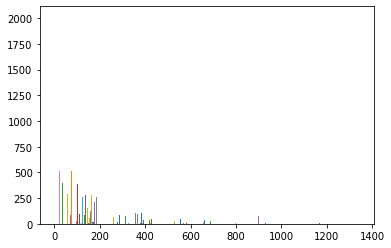

In [183]:
import matplotlib.pyplot as plt
_ = plt.hist(flows_a,bins=100)

Computes the KPI you want with that...

In [ ]:
# TODO

Go back to **II)** if results are not satisfying.

# V Export the final results

First, regenerate a lot more data, then save then

In [ ]:
# TODO generate more data with the same distribution as the one that has been validated

In [ ]:
# TODO export them to be usable in a friendly manner